In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import joblib

import plotly.graph_objects as go

from cfl.cluster_methods.kmeans import KMeans
from cfl.experiment import Experiment
from visual_bars import generate_visual_bars_data as vbd
from cfl.util.data_processing import one_hot_encode
from cfl.dataset import Dataset
from cfl.visualization_methods import clustering_to_sankey as sk


In [2]:
# create a visual bars data set 

n_samples = 10000
noise_lvl = 0.0
im_shape = (10, 10)
random_seed = 143
print('Generating a visual bars dataset with {} samples at noise level {}'.format(n_samples, noise_lvl))

vb_data = vbd.VisualBarsData(n_samples=n_samples, im_shape = im_shape, noise_lvl=noise_lvl, set_random_seed=random_seed)

ims = vb_data.getImages()
y = vb_data.getTarget()
 
# format data 
x = np.expand_dims(ims, -1)

y = one_hot_encode(y, unique_labels=[0,1])

Generating a visual bars dataset with 10000 samples at noise level 0.0


All results from this run will be saved to C:/Users/jkahn/Documents/Schmidt Academy/cfl/dbscan_test\experiment0009
lr specified but not used by CondExpKC
opt_config not specified in input, defaulting to {}
weights_path not specified in input, defaulting to None
loss not specified in input, defaulting to mean_squared_error
show_plot not specified in input, defaulting to True
name not specified in input, defaulting to CondExpKC
standardize not specified in input, defaulting to False
best not specified in input, defaulting to True
Training CFL pipeline.
Epoch 1/5
235/235 [==============================] - 2s 8ms/step - loss: 0.1699 - val_loss: 0.1419
Epoch 2/5
235/235 [==============================] - 1s 4ms/step - loss: 0.1393 - val_loss: 0.1387
Epoch 3/5
235/235 [==============================] - 1s 4ms/step - loss: 0.1377 - val_loss: 0.1372
Epoch 4/5
235/235 [==============================] - 1s 3ms/step - loss: 0.1366 - val_loss: 0.1384
Epoch 5/5
235/235 [============================

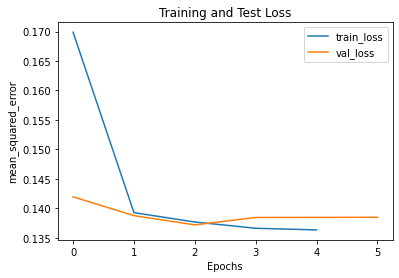

Loading parameters from  tmp_checkpoints/best_weights
Saving parameters to  C:/Users/jkahn/Documents/Schmidt Academy/cfl/dbscan_test\experiment0009\trained_blocks\CondExpKC


In [3]:
lr = 1e-4 # this was 1e-3 in Chalupka's code
CDE_params = {  'batch_size': 32, # this was 10 in Chalupka's code
                    'lr': lr, 
                    'optimizer': 'adam', 
                    'n_epochs': 5, 
                    # 'standardize': True
                 }
data_info = {'X_dims': x.shape, 
             'Y_dims': y.shape, 
             'Y_type': 'categorical'}

block_names = ['CondExpKC']
block_params = [CDE_params]

# save_path = '/Users/imanwahle/Desktop/cfl/examples/exp_results'
save_path = 'C:/Users/jkahn/Documents/Schmidt Academy/cfl/dbscan_test'
my_exp = Experiment(X_train=x, Y_train=y, data_info=data_info, block_names=block_names, block_params=block_params, blocks=None, results_path=save_path)

results = my_exp.train()

In [4]:
pyx = results['CondExpKC']['pyx']

In [5]:
# pyx is n samples long, each subarray contains (P(Y=0), P(Y=1))
pyx[:10]

array([[0.36912006, 0.63088   ],
       [0.900322  , 0.09967804],
       [0.6799978 , 0.32000214],
       [0.22701532, 0.7729846 ],
       [0.02106844, 0.9789315 ],
       [0.03092152, 0.9690785 ],
       [0.01731554, 0.98268443],
       [0.36912006, 0.63088   ],
       [0.26291427, 0.7370857 ],
       [0.04772196, 0.9522781 ]], dtype=float32)

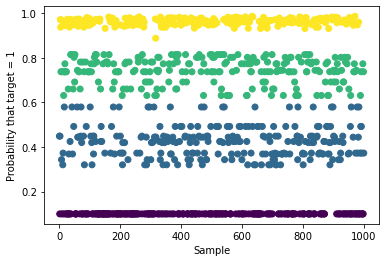

Average prediction for x-class 0: 0.10
Average prediction for x-class 1: 0.42
Average prediction for x-class 2: 0.74
Average prediction for x-class 3: 0.96


In [6]:

truth = vb_data.getGroundTruth()

#choose a thousand random samples from the pyx results 
plot_idx = np.random.choice(pyx.shape[0], 1000, replace=False)

# plot them 
plt.scatter(range(1000), pyx[plot_idx,1], c=truth[plot_idx])
plt.ylabel("Probability that target = 1")
plt.xlabel("Sample")
plt.show()

for i in range(4):
    print('Average prediction for x-class {}: {:.2f}'.format(i, np.mean(pyx[truth==i,1])))


In [7]:
# create a number of DBSCAN objects
from sklearn.cluster import DBSCAN 

eps_range = [0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01]

cde_results_dict = results['CondExpKC']

dbscan_l = []
for n in eps_range:
  dbscan_obj = DBSCAN(eps=n)
  dbscan_l.append(dbscan_obj)

data = Dataset(x, y)

# trained all the data on the kmeanss 
x_lbls_L = []
for dbscan_obj in dbscan_l: 
  clustering = dbscan_obj.fit(pyx)
  x_lbls_L.append(clustering.labels_)

In [8]:
link, label = sk.convert_lbls_to_sankey_nodes(x_lbls_L)
# plot
fig = go.Figure(data=
          [go.Sankey(node = dict(pad = 15, thickness=20, label = label, color =  "blue"),
                     link = link)])
    
fig.update_layout(title_text="Visual Bars (no noise) Clustering, DBSCAN, varying eps={}".format(eps_range), font_size=10)
fig.show()

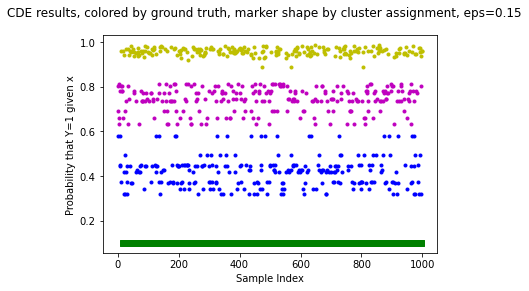

In [9]:
truth = vb_data.getGroundTruth()


# plot them 
markers = ["." , "," , "o" , "v" ]
colors = ['g','b', 'm', 'y']

#choose a thousand random samples from the pyx results 
plot_idx = np.random.choice(pyx.shape[0], 1000, replace=False)

# for each sample 
for i in range(1000):  
    pi = pyx[plot_idx[i],1] # plot probability  
    mi = markers[x_lbls_L[3][plot_idx[i]]] #marker based on cluster assignment
    ci = colors[truth[plot_idx[i]]] #color based on ground truth class

    plt.scatter(i,pi, marker=mi, color=ci) 
plt.xlabel("Sample Index")
plt.ylabel("Probability that Y=1 given x")
plt.suptitle("CDE results, colored by ground truth, marker shape by cluster assignment, eps=0.15")
plt.show() 

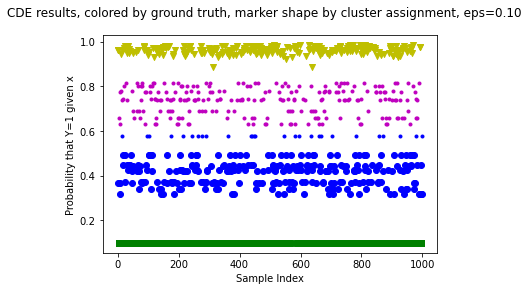

In [10]:
truth = vb_data.getGroundTruth()


# plot them 
markers = ["." , "," , "o" , "v", ">" ]
colors = ['g','b', 'm', 'y']

#choose a thousand random samples from the pyx results 
plot_idx = np.random.choice(pyx.shape[0], 1000, replace=False)

# for each sample 
for i in range(1000):  
    pi = pyx[plot_idx[i],1] # plot probability  
    mi = markers[x_lbls_L[4][plot_idx[i]]] #marker based on cluster assignment
    ci = colors[truth[plot_idx[i]]] #color based on ground truth class

    plt.scatter(i,pi, marker=mi, color=ci) 
plt.xlabel("Sample Index")
plt.ylabel("Probability that Y=1 given x")
plt.suptitle("CDE results, colored by ground truth, marker shape by cluster assignment, eps=0.10")
plt.show() 


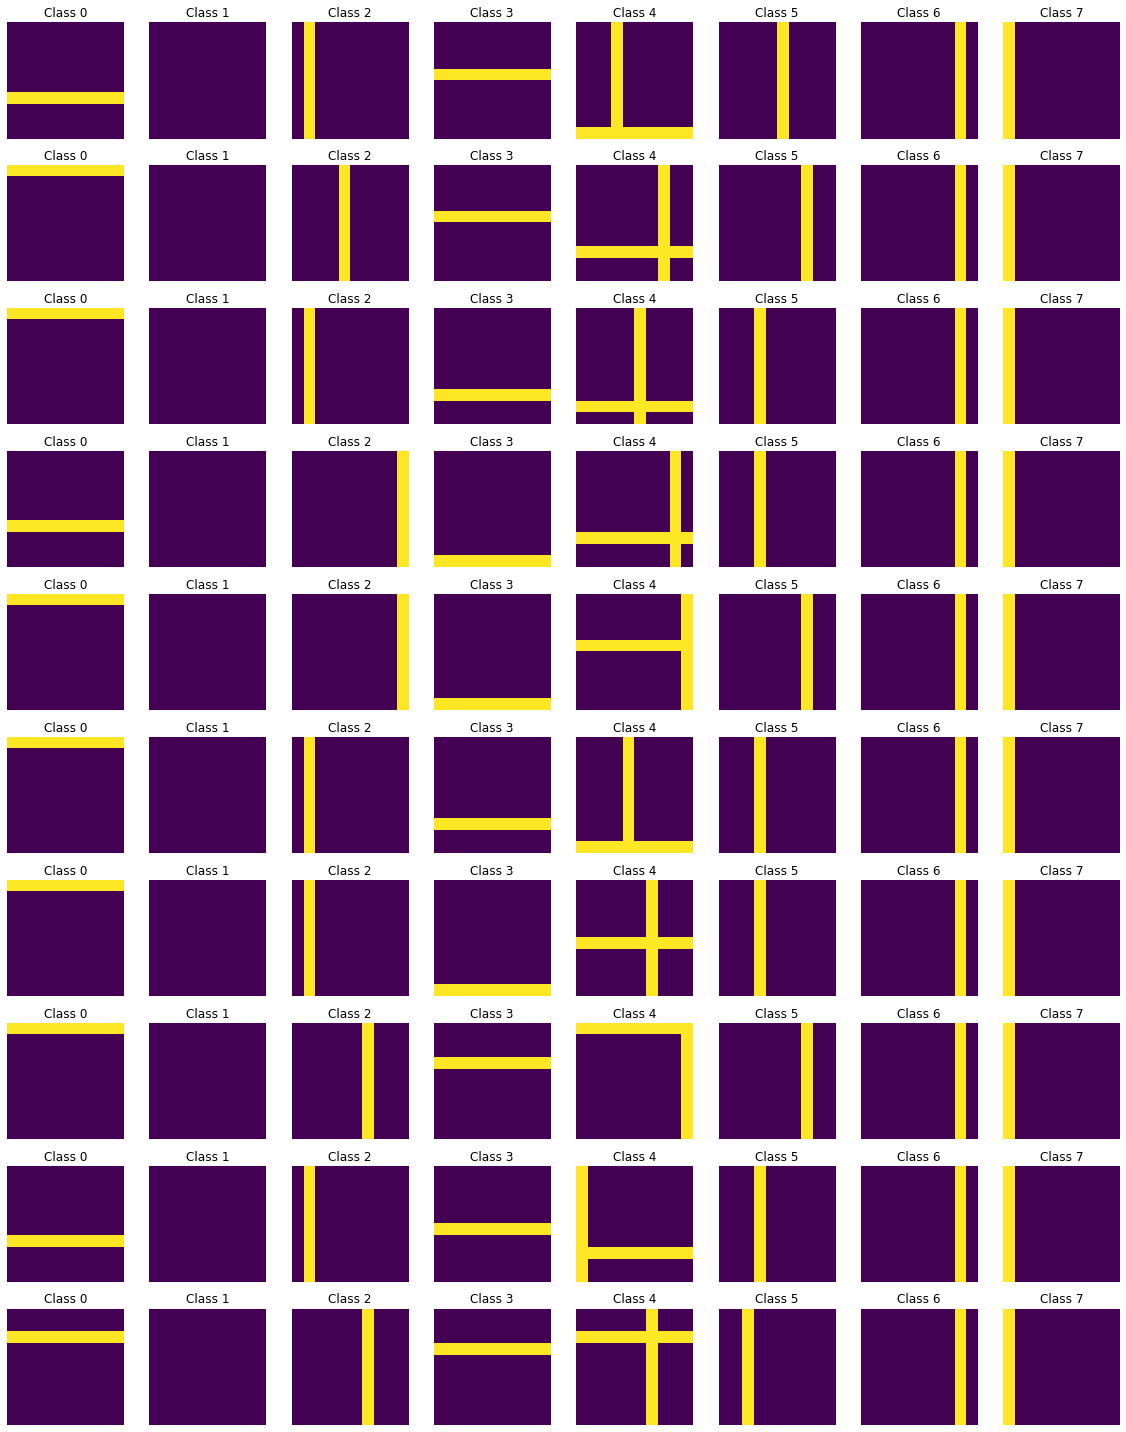

In [11]:
from cfl.visualization_methods import general_vis as vis
vis.view_class_examples(ims, im_shape, 10, x_lbls_L[5])

## With noisy data

Generating a visual bars dataset with 10000 samples at noise level 0.03
All results from this run will be saved to C:/Users/jkahn/Documents/Schmidt Academy/cfl/dbscan_test\experiment0010
name not specified in input, defaulting to CondExpCNN
Training CFL pipeline.
Epoch 1/50
235/235 - 3s - loss: 0.2476 - val_loss: 0.2479
Epoch 2/50
235/235 - 2s - loss: 0.2303 - val_loss: 0.1977
Epoch 3/50
235/235 - 2s - loss: 0.1753 - val_loss: 0.1569
Epoch 4/50
235/235 - 3s - loss: 0.1552 - val_loss: 0.1478
Epoch 5/50
235/235 - 2s - loss: 0.1507 - val_loss: 0.1430
Epoch 6/50
235/235 - 3s - loss: 0.1490 - val_loss: 0.1419
Epoch 7/50
235/235 - 2s - loss: 0.1476 - val_loss: 0.1439
Epoch 8/50
235/235 - 2s - loss: 0.1469 - val_loss: 0.1400
Epoch 9/50
235/235 - 2s - loss: 0.1460 - val_loss: 0.1393
Epoch 10/50
235/235 - 2s - loss: 0.1447 - val_loss: 0.1385
Epoch 11/50
235/235 - 2s - loss: 0.1440 - val_loss: 0.1377
Epoch 12/50
235/235 - 2s - loss: 0.1427 - val_loss: 0.1408
Epoch 13/50
235/235 - 2s - loss: 0.14

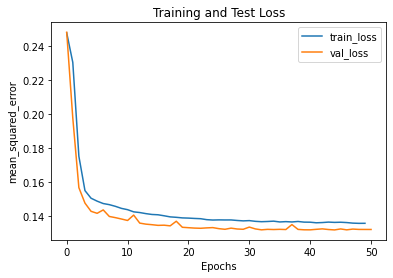

Loading parameters from  tmp_checkpoints/best_weights
Saving parameters to  C:/Users/jkahn/Documents/Schmidt Academy/cfl/dbscan_test\experiment0010\trained_blocks\CondExpCNN


In [12]:
# create a visual bars data set 

n_samples = 10000
noise_lvl = 0.03
im_shape = (10, 10)
random_seed = 143
print('Generating a visual bars dataset with {} samples at noise level {}'.format(n_samples, noise_lvl))

vb_data2 = vbd.VisualBarsData(n_samples=n_samples, im_shape = im_shape, noise_lvl=noise_lvl, set_random_seed=random_seed)

ims = vb_data2.getImages()
y = vb_data2.getTarget()
 
# format data 
x2 = np.expand_dims(ims, -1)

y2 = one_hot_encode(y, unique_labels=[0,1])

data_info = {'X_dims': x2.shape,
             'Y_dims': y2.shape,
             'Y_type': 'categorical'}

# # paragmeters for CDE
CNN_params = { # parameters for model creation
                    'filters'         : [32, 16],
                    'input_shape'     : (10, 10, 1),
                    'kernel_size'     : [(3, 3)] *2,
                    'pool_size'       : [(2, 2)] *2,
                    'padding'         : ['same'] *2,
                    'conv_activation' : ['softmax', 'softmax'],
                    'dense_units'     : 16,
                    'dense_activation' : 'softmax',
                    'output_activation': 'softmax',

                    # parameters for training
                    'batch_size'  : 32,
                    'n_epochs'    : 50,
                    'optimizer'   : 'adam',
                    'opt_config'  : {},
                    'verbose'     : 2,
                    'weights_path': None,
                    'loss'        : 'mean_squared_error',
                    'show_plot'   : True,
                    'standardize' : False,
                    'best'        : True,
                    }


block_names = ['CondExpCNN']
block_params = [CNN_params]

# save_path = '/Users/imanwahle/Desktop/cfl/examples/exp_results'
save_path = 'C:/Users/jkahn/Documents/Schmidt Academy/cfl/dbscan_test'
my_exp2 = Experiment(X_train=x2, Y_train=y2, data_info=data_info, block_names=block_names, block_params=block_params, blocks=None, results_path=save_path)

results2 = my_exp2.train()

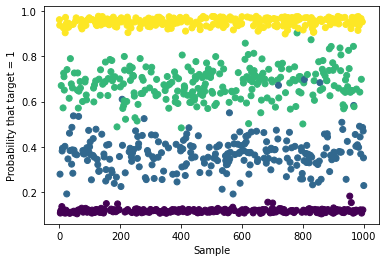

Average prediction for x-class 0: 0.12
Average prediction for x-class 1: 0.38
Average prediction for x-class 2: 0.69
Average prediction for x-class 3: 0.95


In [16]:
truth = vb_data.getGroundTruth()

pyx = results2['CondExpCNN']['pyx']

#choose a thousand random samples from the pyx results 
plot_idx = np.random.choice(pyx.shape[0], 1000, replace=False)

# plot them 
plt.scatter(range(1000), pyx[plot_idx,1], c=truth[plot_idx])
plt.ylabel("Probability that target = 1")
plt.xlabel("Sample")
plt.show()

for i in range(4):
    print('Average prediction for x-class {}: {:.2f}'.format(i, np.mean(pyx[truth==i,1])))


In [50]:
# create a number of DBSCAN objects
eps_range = (0.010, 0.008, 0.006, 0.004, 0.003, 0.002)

cde_results_dict = results2['CondExpCNN']

dbscan_l = []
for n in eps_range:
  dbscan_obj = DBSCAN(eps=n)
  dbscan_l.append(dbscan_obj)

data = Dataset(x, y)

# trained all the data on the kmeanss 
x_lbls_L = []
for dbscan_obj in dbscan_l: 
  clustering = dbscan_obj.fit(pyx)
  x_lbls_L.append(clustering.labels_)

In [51]:
link, label = sk.convert_lbls_to_sankey_nodes(x_lbls_L)
# plot
fig = go.Figure(data=
          [go.Sankey(node = dict(pad = 15, thickness=20, label = label, color =  "blue"),
                     link = link)])
    
fig.update_layout(title_text="Visual Bars (0.03 noise) Clustering, DBSCAN, varying eps={}".format(eps_range), font_size=8)
fig.show()

In [41]:
# Ideas:
# - varying other parameter gives ^4 clusters with little tiny clusters classified as noise?
# collect key plots (show ground truth checks) w lil description 

In [44]:
# SNN: put it on AWS?  (frederick will need to reset my password)
# might be better to start trying with noisy data? perfect categorical stuff might screw it up 
# 

# Vary MinPoints

In [72]:
# create a number of DBSCAN objects
minPoints_range = (1, 2, 3,4 , 5, 6, 7, 8, 9, 10, 11, 12)
eps = 0.003

cde_results_dict = results2['CondExpCNN']

dbscan_l = []
for n in minPoints_range:
  dbscan_obj = DBSCAN(eps=eps, min_samples=n)
  dbscan_l.append(dbscan_obj)

data = Dataset(x, y)

# trained all the data on the kmeanss 
x_lbls_L = []
for dbscan_obj in dbscan_l: 
  clustering = dbscan_obj.fit(pyx)
  x_lbls_L.append(clustering.labels_)

In [69]:
np.unique(x_lbls_L[0])

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
      dtype=int64)

In [73]:
link, label = sk.convert_lbls_to_sankey_nodes(x_lbls_L)
# plot
fig = go.Figure(data=
          [go.Sankey(node = dict(pad = 15, thickness=20, label = label, color =  "blue"),
                     link = link)])
    
fig.update_layout(title_text="Visual Bars (0.03 noise) Clustering, DBSCAN, varying min_samples={}".format(minPoints_range), font_size=8)
fig.show()